# Introduction
This is a Graph Convolutional Networks (GCN) to predict adsorption energy by density of states of mentals.

# Function

In [259]:

import sys
import pickle
import spektral
import visualkeras
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers

from spektral import models
from spektral.models.gnn_explainer import GNNExplainer
from spektral.data import Graph, Dataset, DisjointLoader
from spektral.layers import ECCConv, GlobalSumPool, GlobalAvgPool

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.layers import Input, BatchNormalization, Dropout, Dense, AveragePooling1D, Concatenate, Conv1D, Flatten
from tensorflow.keras.models import Model

sys.executable

# TSNE PCA
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [260]:
tf.config.run_functions_eagerly(True)
print(tf.executing_eagerly())

True


# Load Data

In [261]:
class MyGraphDataset(Dataset):
    """
    A dataset of density of states of mentals
    """

    def __init__(self, graph_list, **kwargs):
        self.graph_list = graph_list
        super().__init__(**kwargs)

    def download(self):
        if self.path is None:
            print("self.path is None")
        else:
            with open(self.path, "wb") as file:
                pickle.dump(self.graph_list, file)

    def read(self):
        # We must return a list of Graph objects
        output = []
        for i in range(len(self.graph_list)):
            output.append(self.graph_list[i])
        return output

    def __len__(self):
        return len(self.graph_list)

    def __getitem__(self, index):
        return self.graph_list[index]

In [262]:
# 从文件中提取数据
data_path = "./vasp_cal/"  # 当前文件执行的文件夹，包括输出和输入文件夹
dos_energy_data_file = data_path + "dos_energy_data.pkl"
with open(dos_energy_data_file, "rb") as file:
    dataset1 = pickle.load(file)

print(dataset1)  # 输出：[1, 2, 3, 4, 5]
dataset1[0].x.shape

MyGraphDataset(n_graphs=126)


(8, 2000)

In [263]:
# 从文件中提取数据
file_path = "/home/zwbai/work/ocp-main/ocp/new/vasp_cala/dos_energy_data.pkl"
with open(file_path, "rb") as file:
    dataset2 = pickle.load(file)

print(dataset2)  # 输出：[1, 2, 3, 4, 5]
dataset2[0].x.shape

MyGraphDataset(n_graphs=594)


(8, 2000)

In [264]:
graph_data = []
for i in range(len(dataset1)):
    g = dataset1[i]
    graph_data.append(g)
for i in range(len(dataset2)):
    g = dataset2[i]
    graph_data.append(g)

dataset = MyGraphDataset(graph_data)
dataset

MyGraphDataset(n_graphs=720)

# Build GCN model

In [265]:
F = dataset.n_node_features  # Dimension of node features
S = dataset.n_edge_features  # Dimension of edge features
n_out = dataset.n_labels  # Dimension of the target
F, S, n_out

(2000, 4, 1)

In [266]:
learning_rate = 1e-4  # Learning rate
epochs = 40  # Number of training epochs
batch_size = 32  # Batch size

In [267]:
def dos_featurize(length, channel):
    input_dos = Input(shape=(length, channel))  # 400, 5
    x1 = AveragePooling1D(pool_size=2, strides=4, padding="same")(input_dos)  # 窗口 步长
    x2 = AveragePooling1D(pool_size=4, strides=4, padding="same")(input_dos)
    x3 = AveragePooling1D(pool_size=8, strides=4, padding="same")(input_dos)
    x = Concatenate(axis=-1)([x1, x2, x3])  # 沿着最后一个轴拼接
    x = Conv1D(250, 6, activation="relu", padding="same", strides=2)(x)
    x = BatchNormalization()(x)
    x = Conv1D(175, 3, activation="relu", padding="same", strides=2)(x)
    x = AveragePooling1D(pool_size=3, strides=2, padding="same")(x)
    x = Conv1D(150, 3, activation="relu", padding="same", strides=2)(x)
    x = AveragePooling1D(pool_size=3, strides=2, padding="same")(x)
    x = Conv1D(125, 3, activation="relu", padding="same", strides=2)(x)
    x = AveragePooling1D(pool_size=3, strides=2, padding="same")(x)
    x = Conv1D(100, 3, activation="relu", padding="same", strides=2)(x)
    x = tf.squeeze(x)
    shared_model = Model(input_dos, x)
    return shared_model

channels = 5
length = int(F / channels)  # 400
shared_conv = dos_featurize(length, channels)

# 

In [268]:
class Net(Model):
    
    def __init__(self):
        super().__init__()
        self.share = shared_conv
        self.conv1 = ECCConv(256, activation="relu")
        self.conv2 = ECCConv(128, activation="relu")
        # self.conv3 = ECCConv(128, activation="relu")
        self.global_pool = GlobalAvgPool()
        self.dense0 = Dense(64)
        self.dense = Dense(n_out)

    def call(self, inputs):
        x, a, e, i = inputs
        x = tf.reshape(x, (-1, length, channels))
        x = shared_conv(x) # dos feature


        x = self.conv1([x, a, e])
        x = self.conv2([x, a, e])
        output = self.global_pool([x, i])
        output = tf.keras.layers.Flatten()(output)
        output = self.dense0(output)
        output = self.dense(output)

        return output

In [269]:
model = Net()
model.layers

In [270]:
learning_rate = 1e-3
optimizer = Adam(learning_rate)
loss_fn = MeanSquaredError()

# Train/valid/test split
data = np.array(graph_data)
idxs = np.random.permutation(len(data))
split_va_te = int(0.90 * len(data))
idx_tr, idx_va = np.split(idxs, [split_va_te])
data_tr = data[idx_tr]
data_va = data[idx_va]

loader_tr = DisjointLoader(MyGraphDataset(data_tr), batch_size=batch_size, epochs=epochs)
loader_va = DisjointLoader(MyGraphDataset(data_va), batch_size=1, epochs=1)

In [271]:
# Fit model
@tf.function(input_signature=loader_tr.tf_signature(), experimental_relax_shapes=True)
def train_step(inputs, target):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(target, predictions) + sum(model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [272]:
istrain = True
if istrain:
    step = loss = 0
    for batch in loader_tr:
        step += 1
        loss += train_step(*batch)
        if step == loader_tr.steps_per_epoch:
            step = 0
            print("Loss: {}".format(loss / loader_tr.steps_per_epoch))
            loss = 0
    model.save_weights('./vasp_cal/model_weightas') # 保存GCN權重

/home/zwbai/miniconda3/envs/ocp-models2/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'MyGraphDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Loss: 0.4085472524166107
Loss: 0.13246572017669678
Loss: 0.08712510019540787
Loss: 0.06227037310600281
Loss: 0.04281361401081085
Loss: 0.035129815340042114
Loss: 0.023739419877529144
Loss: 0.016311291605234146
Loss: 0.012919563800096512
Loss: 0.011460291221737862
Loss: 0.01112272683531046
Loss: 0.009786988608539104
Loss: 0.009685150347650051
Loss: 0.008149402216076851
Loss: 0.007752156816422939
Loss: 0.007015972398221493
Loss: 0.006522229872643948
Loss: 0.006302741356194019
Loss: 0.00617998605594039
Loss: 0.006325980182737112
Loss: 0.0061636921018362045
Loss: 0.0062104505486786366
Loss: 0.005982222501188517
Loss: 0.005937258247286081
Loss: 0.006085865665227175
Loss: 0.006192995700985193
Loss: 0.006073313299566507
Loss: 0.005910628009587526
Loss: 0.005863752216100693
Loss: 0.006075917277485132
Loss: 0.005861634388566017
Loss: 0.0056861634366214275
Loss: 0.005927486810833216
Loss: 0.0058306483551859856
Loss: 0.005982105154544115
Loss: 0.005654860287904739
Loss: 0.005915777757763863
Loss:

In [273]:
if istrain == False:
    model.load_weights('./vasp_cal/model_weightas') # 加载GCN权重

In [274]:
# Train/valid/test split
data = np.array(graph_data)
idxs = np.random.permutation(len(data))
split_va_te = int(0.9 * len(data))
idx_tr, idx_va = np.split(idxs, [split_va_te])
data_tr = data[idx_tr]
data_va = data[idx_va]

# Data loaders
loader_tr = DisjointLoader(MyGraphDataset(data_tr), batch_size=1, epochs=1)
loader_va = DisjointLoader(MyGraphDataset(data_va), batch_size=1, epochs=1)

In [275]:
# 对训练集进行预测
predictions = []
targets = []
for batch in loader_tr:
    output = model(batch[0], training=False)
    predictions.append(output)
    targets.append(batch[1])
predictions = np.concatenate(predictions, axis=0)
targets = np.concatenate(targets, axis=0)
# 组合预测值和真实值
data0 = np.concatenate([predictions, targets], axis=1)

# 对测试集进行预测
predictions = []
targets = []
for batch in loader_va:
    output = model(batch[0], training=False)
    predictions.append(output)
    targets.append(batch[1])
predictions = np.concatenate(predictions, axis=0)
targets = np.concatenate(targets, axis=0)

# 组合预测值和真实值
data1 = np.concatenate([predictions, targets], axis=1)

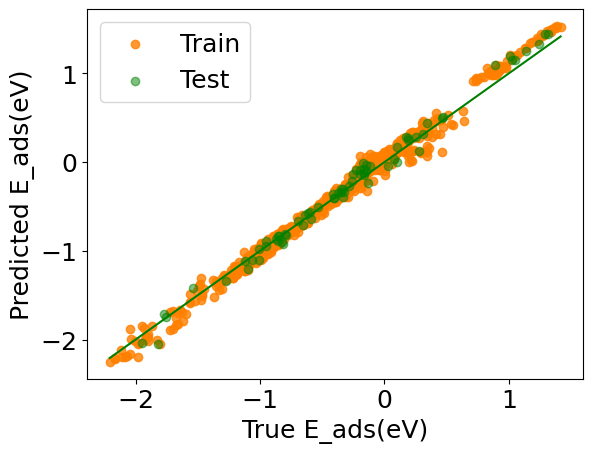

In [276]:
# 画图
plt.rcParams.update({"font.size": 18})

plt.scatter(data0[:, 1], data0[:, 0], color=(1, 0.5, 0, 0.8), label="Train")
plt.scatter(data1[:, 1], data1[:, 0], color=(0, 0.5, 0, 0.5), label="Test")

plt.plot(
    [min(data0[:, 1]), max(data0[:, 1])],
    [min(data0[:, 1]), max(data0[:, 1])],
    color="green",
)

plt.xlabel("True E_ads(eV)")
plt.ylabel("Predicted E_ads(eV)")
plt.legend()
plt.show()

In [277]:
class FeatureExtraction(Model):
    def __init__(self):
        super().__init__()
        self.share = shared_conv
        self.conv1 = ECCConv(128, activation="relu")
        self.conv2 = ECCConv(128, activation="relu")
        # self.conv3 = ECCConv(128, activation="relu")
        self.global_pool = GlobalAvgPool()
        self.dense0 = Dense(64)
        self.dense = Dense(n_out)

    def call(self, inputs):
        x, a, e, i = inputs
        x = tf.reshape(x, (-1, length, channels))
        x = shared_conv(x)

        x = self.conv1([x, a, e])
        feature1 = x  # 保存第一层卷积的特征
        x = self.conv2([x, a, e])
        feature2 = x  # 保存第二层卷积的特征
        output = self.global_pool([x, i])
        output = tf.keras.layers.Flatten()(output)
        output = self.dense0(output)
        feature3 = output
        output = self.dense(output)

        return output, feature1, feature2, feature3  # 返回输出和需要提取的特征\

Model_feature = FeatureExtraction()

In [278]:
def plot_feature(X_embedded, z):
    dim = X_embedded.shape[1]
    # 创建彩虹图的 colormap
    cmap = plt.get_cmap("rainbow")

    # 创建彩虹图的 colormap
    cmap = plt.get_cmap("viridis")

    # 设置合适的数值范围
    vmin = np.min(z)
    vmax = np.max(z)
    fig = plt.figure()
    
    if dim == 1:
        ax = fig.add_subplot()
        ax.scatter(X_embedded[:, 0], z, c=z, cmap=cmap)
        ax.set_xticks([])  # 移除y轴刻度
    elif dim == 2:
        ax = fig.add_subplot()
        ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c=z, cmap=cmap)
        ax.set_xticks([])  # 移除x轴刻度
        ax.set_yticks([])  # 移除y轴刻度
    elif dim == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], c=targets, cmap=cmap)
        ax.set_xticks([])  # 移除x轴刻度
        ax.set_yticks([])  # 移除y轴刻度
        ax.set_zticks([])  # 移除z轴刻度

    # ax.set_axis_off()  # 移除所有坐标轴刻度
    
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])  # 设置一个空数组，传递给 colorbar
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label("Adsorption Energy (eV)")
    plt.show()

In [279]:
# Data loaders
loader_data = DisjointLoader(MyGraphDataset(data), batch_size=1, epochs=1)
predictions, targets, feature1, feature2, feature3 = [], [], [], [], []
for batch in loader_data:
    output, f1, f2, f3 = Model_feature(batch[0], training=False)
    predictions.append(output)
    feature1.append(f1)
    feature2.append(f2)
    feature3.append(f3)
    targets.append(batch[1])
predictions = np.concatenate(predictions, axis=0)
targets = np.concatenate(targets, axis=0)
# 组合预测值和真实值
data0 = np.concatenate([predictions, targets], axis=1)

In [280]:
fone = [f.numpy().reshape((1, -1))[0] for f in feature1]
fone = np.array(fone)
fone.shape

(720, 1024)

In [281]:
X_embedded = TSNE(
    n_components=2, learning_rate="auto", init="random", perplexity=3
).fit_transform(fone)

In [282]:
ftwo = [f.numpy().reshape((1, -1))[0] for f in feature2]
ftwo = np.array(ftwo)
ftwo.shape

fthree = [f.numpy().reshape((1, -1))[0] for f in feature3]
fthree = np.array(fthree)
fthree.shape

(720, 64)

In [283]:
X_embedded = TSNE(
    n_components=2, learning_rate="auto", init="random", perplexity=3
).fit_transform(ftwo)

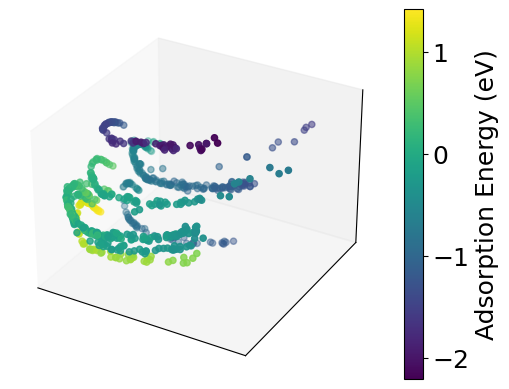

In [296]:
pca3 = PCA(n_components=3)
X_embedded = pca3.fit_transform(fthree)
plot_feature(X_embedded, targets)

In [304]:
datatest = data[0].x[0].reshape((-1,5))
x = 

In [305]:
datatest

array([[0.0207, 0.0247, 0.0481, 0.0251, 0.0224],
       [0.0213, 0.0253, 0.0483, 0.0258, 0.023 ],
       [0.0218, 0.0259, 0.0486, 0.0265, 0.0236],
       [0.0224, 0.0266, 0.0488, 0.0272, 0.0242],
       [0.023 , 0.0274, 0.049 , 0.028 , 0.0249],
       [0.0236, 0.0282, 0.0492, 0.0288, 0.0257],
       [0.0242, 0.0291, 0.0495, 0.0297, 0.0265],
       [0.0249, 0.0301, 0.0497, 0.0306, 0.0273],
       [0.0257, 0.0311, 0.05  , 0.0316, 0.0283],
       [0.0265, 0.0323, 0.0503, 0.0327, 0.0294],
       [0.0274, 0.0335, 0.0506, 0.0339, 0.0305],
       [0.0284, 0.0348, 0.051 , 0.0352, 0.0317],
       [0.0295, 0.0361, 0.0514, 0.0365, 0.0329],
       [0.0306, 0.0374, 0.0518, 0.0379, 0.0342],
       [0.0319, 0.0388, 0.0523, 0.0394, 0.0354],
       [0.0332, 0.0401, 0.0528, 0.0409, 0.0366],
       [0.0345, 0.0413, 0.0532, 0.0424, 0.0378],
       [0.0359, 0.0425, 0.0537, 0.0439, 0.0388],
       [0.0373, 0.0437, 0.0542, 0.0454, 0.0397],
       [0.0386, 0.0447, 0.0547, 0.047 , 0.0405],
       [0.0399, 0.04